In [1]:
!pip install langgraph tavily-python langchain-community langchain_anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.3 MB/s eta 0:00:00 MB/s eta 0:00:01:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached aiohttp-3.9.5-cp311-cp311-macosx_11_0_arm64.whl (390 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 14.1 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.4/865.4 kB 19.6 MB/s eta 0:00:00m eta 0:00:01
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached frozenlist-1.4.1-cp311-cp311-macosx_11_0_arm64.whl (53 kB)
  Using cached multidict-6.0.5-cp311-cp311-macosx_11_0_arm64.whl (30 kB)
  Using cached yarl-1.9.4-cp311-cp311-macosx_11_0_arm64.whl (81 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 12.2 MB/s eta 0:00:00
  Using cached tokenizers-0.19.1-cp311-cp311-macosx_11_0_arm64.whl (2.4 MB)
  Using cached marshmallow-3.21.3-py

In [1]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = "true"

In [2]:
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from langchain_anthropic import ChatAnthropic
import json
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict
from langgraph.graph import StateGraph, END

In [4]:
raw_model = ChatAnthropic(model_name="claude-3-5-sonnet-20240620")

In [70]:
class Info(BaseModel):
    language: str
    prospect: Literal["Public Company", "Large Private Company", "AI Native Early Legit Startup", "Early Legit Startup", "Early Startup", "AI Native Early Startup", "AI Native Pre-Company", "Other", "Personal", "Consultancy", "Education"]
    horizontal: bool
    interest_reasoning: str
    interest_score: int

In [71]:
model = raw_model.with_structured_output(Info)

In [72]:
prompt = """You are doing research on companies. All these companies signed up for LangChain waitlist. \
LangChain is an LLMOps company. Your job is to fill out information about these companies that will help \
determine which ones are interesting to look at.

The information you should be gathering is:

Language: The language of the website, should be ISO 639 three-letter (set 2) codes (eng, fra, etc)

Horizontal: Whether this is a horizontal AI company or not. Horizontal AI companies include low-code platforms for building \
generic LLM applications

Prospect: What type of company this is. This includes:
- Public Company: if they are a publicly traded company
- Large Private Company: greater than 1 bil valuation
- AI Native Early Legit Startup: A legit startup (top tier investors) that is built around AI
- Early Legit Startup: A legit startup (top tier investors) that is NOT built around AI
- AI Native Early Startup: A early stage startup that does not have top tier VCs or real revenue but has some investment/revenue
- Early Startup: A early stage startup that does not have top tier VCs or real revenue but has some investment/revenue
- AI Native Pre-Company: A super early startup, or one that does not have any investment from good VCs or revenue
- Personal: personal websites
- Consultancy
- Education
- Other: doesn't fit any of the above categories

Interest: How interesting overall this company seems for LangChain to engage. Companies that are interesting are generally \
English speaking, hot, fast moving vertical startups or large private companies. However, if a "logo" would be good to \
have on LangChain website, then that is also interesting. The more information they provide in the `Info` field, \
that likely means they are more engaged, and therefor it is more interesting. \
If the company is horizontal, or seems to be consulting, they are less interesting. There are two fields here to fill out:
- Interest Reasoning: Reasoning for why or why not this company is interesting
- Interest Score: Score between 1-10 for how interesting this company is, 10 being more interesting

When filling out the form, they specified some information about how they hope to use the product. \
This was an optional field. The information they specified was:

<info>
{info}
</info>

Based on the below website, fill out information about the company {company_name}.

{website}"""

In [73]:


class State(TypedDict):
    url: str
    company_name: str
    info: str
    website: str
    response: Info
    new_url: str

In [74]:
def load_website(state: State):
    try:
        loader = WebBaseLoader("https://" + state['url'])
        docs = loader.load()
        return {"website": docs[0].page_content}
    except:
        pass

In [83]:
tool = TavilySearchResults()

class NewUrl(BaseModel):
    url: str

class Nothing(BaseModel):
    nothing: bool
    
def research_website(state: State):
    results = TavilySearchResults().run(state["company_name"])
    
    prompt = """You are trying to find the correct url for a given company. Here is the company info:
    
    name: {company_name}
    domain: {url}
    
    The domain was not found, so we think it is wrong. We searched for the company name, and got the following results:
    
    {results}
    
    Based on these results, either (a) try a new URL, or (b) decide that there is nothing present and give up. \
    If generating the URL, do not include the prefix (eg return `foo.com` not `https://foo.com`"""
    
    response = raw_model.bind_tools([NewUrl, Nothing]).invoke(prompt.format(
        results = results,
        company_name= state["company_name"],
        url=state["url"]
    ))
    if len(response.tool_calls) == 1:
        if response.tool_calls[0]['name'] == 'NewUrl':
            return {"new_url": response.tool_calls[0]['args']['url']}

In [84]:
def get_info(state: State):
    p = prompt.format(company_name=state['company_name'], website=state['website'], info=state['info'])
    result = model.invoke(p)
    return {"response": result}

In [85]:
def initial_success(state: State):
    if "website" not in state or not state['website']:
        return "research_website"
    else:
        return "get_info"

def load_new_website(state: State):
    try:
        loader = WebBaseLoader("https://" + state['new_url'])
        docs = loader.load()
        return {"website": docs[0].page_content}
    except:
        pass

def found_website(state: State):
    if "new_url" in state:
        return "load_new_website"
    else:
        return END


In [86]:
graph = StateGraph(State)
graph.add_node(load_website)
graph.add_node(get_info)
graph.add_node(load_new_website)
graph.add_node(research_website)
graph.add_conditional_edges("load_website", initial_success)
graph.add_conditional_edges("research_website", found_website)
graph.add_edge("load_new_website", "get_info")
graph.add_edge("get_info", END)
graph.set_entry_point("load_website")
graph = graph.compile()

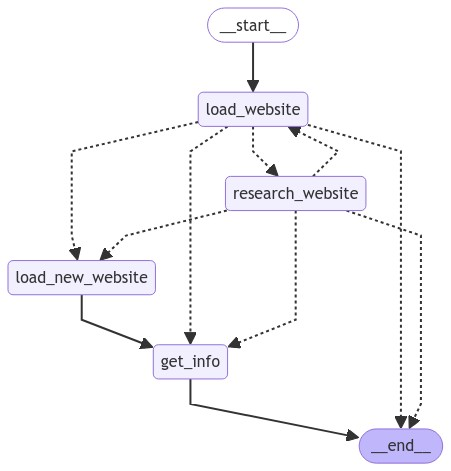

In [87]:

from IPython.display import Image, display

Image(graph.get_graph().draw_mermaid_png())

In [88]:
import pandas as pd
df = pd.read_csv('/Users/harrisonchase/Downloads/Table 1-All.csv')

In [89]:
records = df.to_dict(orient="records")
records = [{"url": r['Domain'], 'company_name': r['Company Name'], "info": r['Problems']} for r in records]

In [90]:
results = graph.batch(records[10:20])

In [93]:
for r in results[:1]:
    r1 = r.copy()
    r1['response'] = r['response'].dict()
    print(json.dumps({k:v for k,v in r1.items() if k != "website"}, indent=2))
    print("----------------------")

{
  "url": "ibm.com",
  "company_name": "IBM",
  "info": "Easy deployment and development!",
  "response": {
    "language": "eng",
    "prospect": "Public Company",
    "horizontal": false,
    "interest_reasoning": "IBM is a large, well-established public company with significant resources and a strong focus on AI and cloud technologies. They are actively involved in developing and implementing AI solutions across various industries. While they are not a startup or fast-moving vertical company, having IBM as a client would be a significant logo for LangChain. Their interest in \"easy deployment and development\" aligns well with LangChain's offerings. However, as a large corporation, they may have their own in-house solutions, which could limit their engagement.",
    "interest_score": 7
  }
}
----------------------
